In [12]:
from utility import *

from collections import Counter
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns

%matplotlib inline

# Dataset Loading

The data sets needed for the loaders can be found at snap.stanford.edu/decagon. The side effect information was curated from the TWOSIDES, OFFSIDES, and Sider databases.

In [13]:
combo2stitch, combo2se, se2name = load_combo_se()
net, node2idx = load_ppi()
stitch2se, se2name_mono = load_mono_se()
stitch2proteins = load_targets(fname='bio-decagon-targets-all.csv')
se2class, se2name_class = load_categories()
se2name.update(se2name_mono)
se2name.update(se2name_class)

Reading: bio-decagon-combo.csv
Drug combinations: 63473 Side effects: 1318
Drug-drug interactions: 4651131
Reading: bio-decagon-ppi.csv
Edges: 715612
Nodes: 19081
Reading: bio-decagon-mono.csv
Reading: bio-decagon-targets-all.csv
Reading: bio-decagon-effectcategories.csv


# Basic Statistics

## How many side effects does each drug combination have?

In [14]:
def plot_distribution(dist, title="", x_label="", y_label="", file_name=None):
    plt.figure(figsize=(6, 3.5))
    sns.set_context("paper", font_scale=1.8)
    sns.set_style('ticks')
    sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
    sns.distplot(dist, kde=False, color=sns.xkcd_rgb['red'], bins=20, hist_kws={"alpha" : 1})
    plt.xlabel(x_label)
    plt.title(title)
    plt.tight_layout()
    plt.gcf().subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
    plt.ylabel(y_label)
    if file_name:
        plt.savefig(file_name)


Median number of side effects per drug combination 53.0


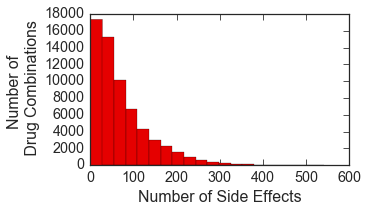

In [15]:
distribution_combos = [len(combo2se[combo]) for combo in combo2se]
print "Median number of side effects per drug combination", np.median(distribution_combos)
plot_distribution(distribution_combos, "", "Number of Side Effects", "Number of \n Drug Combinations", "")

## How frequent are different side effects?

In [16]:
from IPython.display import display, HTML

def get_se_counter(se_map):
    side_effects = []
    for drug in se_map:
        side_effects += list(set(se_map[drug]))
    return Counter(side_effects)

combo_counter = get_se_counter(combo2se)

print("Most common side effects in drug combinations:")
common_se = []
common_se_counts = []
common_se_names = []
for se, count in combo_counter.most_common(20):
    common_se += [se]
    common_se_counts += [count]
    common_se_names += [se2name[se]]
df = pd.DataFrame(data={"Side Effect": common_se, "Frequency in Drug Combos": common_se_counts, "Name": common_se_names})  
display(df)

Most common side effects in drug combinations:


,Frequency in Drug Combos,Name,Side Effect
0,28568,arterial pressure NOS decreased,C0020649
1,27006,anaemia,C0002871
2,26037,Difficulty breathing,C0013404
3,25190,nausea,C0027497
4,24430,neumonia,C0032285
5,24260,Fatigue,C0015672
6,23894,Pain,C0030193
7,23848,diarrhea,C0011991
8,23515,asthenia,C0004093
9,23043,emesis,C0042963


### Plot of Side Effect Frequency

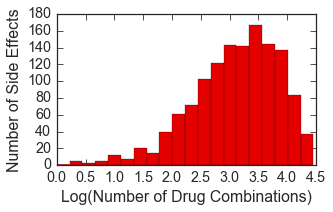

In [17]:
plot_distribution(np.log10(np.asarray(list(zip(*combo_counter.items())[1]))), "",  "Log(Number of Drug Combinations)", "Number of Side Effects", file_name="se_combodist.pdf")

# Side Effect Cooccurrence in Drug Combinations

In [18]:
combos = combo2se.keys()
combo_probability_distribution = np.asarray([len(combo2se[combo])*1.0 for combo in combo2se])
combo_probability_distribution = combo_probability_distribution/np.sum(combo_probability_distribution)

se2combo = defaultdict(set)
for combo in combo2se:
    for se in combo2se[combo]:
        se2combo[se].add(combo)


We observe that polypharmacy side effects do not appear independently of one another in co-prescribed drug pairs (\ie, drug combinations), suggesting that joint modeling over multiple side effects can aid in the prediction task. To quantify the co-occurrence between side effects, we count the number of drug combinations in which a given side effect co-occurs with other side effects, and then use permutation testing with a null model of random co-occurrence. As exemplified for hypertension and nausea below, we find that the majority of the most common side effects are either significantly overrepresented or underrepresented with respect to how often they co-occur with nausea/hypertension as side effects in drug combinations, at $\alpha=0.05$. 

In [19]:
# Permutation test testing the significancy between the drug combinations a side effect occurs in,
# as compared to other common side effects
def run_permutation_test(se_oi, num_permutations = 2000):
    se_oi_combos = se2combo[se_oi]
    side_effects = []
    names = []
    real_overlaps = []
    mean_permuted_overlap = []
    probabilities = []
    for se, count in combo_counter.most_common(51):
        if se == se_oi:
            continue
        real_combos = se2combo[se]
        real_overlap = len(real_combos.intersection(se_oi_combos))
        permuted_overlaps = []
        for i in range(num_permutations):
            combo_sample = np.random.choice(combos, len(real_combos), replace=False, p=combo_probability_distribution)
            permuted_overlaps += [len(se_oi_combos.intersection(set(combo_sample)))]
        probability = np.sum(np.asarray(permuted_overlaps) >= real_overlap)*1.0/num_permutations
        side_effects += [se]
        names += [se2name[se]]
        real_overlaps += [real_overlap]
        mean_permuted_overlap += [np.mean(permuted_overlaps)]
        probabilities += [probability]
    df = pd.DataFrame(data={"Side Effect": side_effects, "True Overlap": real_overlaps, "Mean Permuted Overlap": mean_permuted_overlap, "Probability True < Permuted": probabilities, "Name": names})  
    df = df[['Side Effect', 'Name', 'True Overlap', 'Mean Permuted Overlap', 'Probability True < Permuted']]
    display(df)

In [20]:
# For hypertension
run_permutation_test('C0020538')

,Side Effect,Name,True Overlap,Mean Permuted Overlap,Probability True < Permuted
0,C0020649,arterial pressure NOS decreased,10557,11168.6310,1.0000
1,C0002871,anaemia,9457,10625.5935,1.0000
2,C0013404,Difficulty breathing,9974,10284.1575,1.0000
3,C0027497,nausea,9326,9983.4730,1.0000
4,C0032285,neumonia,9032,9710.2255,1.0000
5,C0015672,Fatigue,9169,9648.1485,1.0000
6,C0030193,Pain,9804,9517.4920,0.0000
7,C0011991,diarrhea,8625,9499.6700,1.0000
8,C0004093,asthenia,9150,9379.2765,1.0000
9,C0042963,emesis,8227,9205.6620,1.0000


In [21]:
# For nausea
run_permutation_test('C0027497')

,Side Effect,Name,True Overlap,Mean Permuted Overlap,Probability True < Permuted
0,C0020649,arterial pressure NOS decreased,13623,13817.6665,1.0000
1,C0002871,anaemia,12668,13141.3570,1.0000
2,C0013404,Difficulty breathing,12823,12715.3290,0.0215
3,C0032285,neumonia,11075,11998.8955,1.0000
4,C0015672,Fatigue,13570,11921.7745,0.0000
5,C0030193,Pain,12699,11760.4490,0.0000
6,C0011991,diarrhea,13492,11740.9805,0.0000
7,C0004093,asthenia,13137,11587.6845,0.0000
8,C0042963,emesis,16363,11377.2805,0.0000
9,C0085649,edema extremities,11139,10890.9000,0.0000


# How similar are the drug target profiles of drug combinations?

Third, we probe the relationship between proteins targeted by a drug pair and occurrence of side effects. Let $T_i$ represent a set of target proteins associated with drug $i$, we then calculate the Jaccard similarity between target proteins of a given drug pair $(i,j)$ as: $\text{Jaccard}(i,j) = |T_i \cap T_j|/|T_i \cup T_j|$.  
We see most drug combinations have zero target proteins in common, random drug pairs have smaller overlap in targeted proteins than co-prescribed drugs, andthat this trend is unequally observed across different side effects. 

In [23]:
def jaccard(set1, set2):
    num = len(set(set1).intersection(set(set2)))
    den = len(set(set1).union(set(set2)))
    return num*1.0/den

# Only examining those drugs we have drug target information for
valid = []
for stitch in stitch2se:
    if len(stitch2proteins[stitch]) > 0:
        valid += [stitch]
        
# Jaccard similarity between drug target profiles of drugs in drug combinations
jaccard_combos = {}
for combo in combo2se:
    stitch1, stitch2 = combo2stitch[combo]
    if stitch1 in valid and stitch2 in valid:
        jaccard_combos[combo] = jaccard(stitch2proteins[stitch1], stitch2proteins[stitch2])
        
# Jaccard similarity between drug target profiles of random drugs
jaccard_random = []
for i in range(len(jaccard_random)):
    stitch1 = np.random.choice(valid, 1, replace=False)[0]
    stitch2 =  np.random.choice(valid, 1, replace=False)[0]
    jaccard_random += [jaccard(stitch2proteins[stitch1], stitch2proteins[stitch2])] 
jaccard_random = np.asarray(jaccard_random)

In [24]:
import pandas as pd

def plot_jaccard_distribution_multiple(ses):
    group_names = {'Random drug pairs': jaccard_random, 'All drug combinations': np.asarray([jaccard_combos[combo] for combo in jaccard_combos])}
    order = ['Random drug pairs', 'All drug combinations'] + [nicknames[se] for se in ses]
    for se in ses:
        se_combos = se2combo[se].intersection(set(jaccard_combos.keys()))
        in_jaccard = np.asarray([jaccard_combos[combo] for combo in se_combos])
        group_name = nicknames[se]
        group_names[group_name] = in_jaccard
    categories = {'No shared drug targets': (-.01, 0), 'Fewer than 50% shared': (0, 0.5), 'More than 50% shared':(0.5, 1)}
    groups, similarities, fractions = [], [], []
    for name in group_names:
        arr = group_names[name]
        for category in categories: 
            min_val, max_val = categories[category]
            value = np.sum((arr > min_val) * (arr <= max_val))*1.0/len(arr)
            groups += [name]
            similarities += [category]
            fractions += [value]
    data = pd.DataFrame({ '' : groups, 'Jaccard Similarity Between Drug Target Profiles': similarities, 'Fraction of Drug Combinations': fractions})
    plt.figure(figsize=(3, 5))
    sns.set_context("paper", font_scale=6)
    sns.set_style('ticks')
    sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
    g = sns.factorplot(x="Jaccard Similarity Between Drug Target Profiles", y="Fraction of Drug Combinations", hue="", data=data,
                   size=18, kind="bar", palette=['#535456', '#9ea3a8', '#3478e5', '#e74c3c', '#2ecc71', '#cc6c18', '#9b59b6',], x_order=['No shared drug targets','Fewer than 50% shared','More than 50% shared'], hue_order=order)
    plt.tight_layout()
    plt.xlabel('')
    plt.savefig('multiple_dist.pdf')


/Users/monicaagrawal/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Users/monicaagrawal/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:3304: UserWarning: The `x_order` parameter has been renamed `order`
  UserWarning)


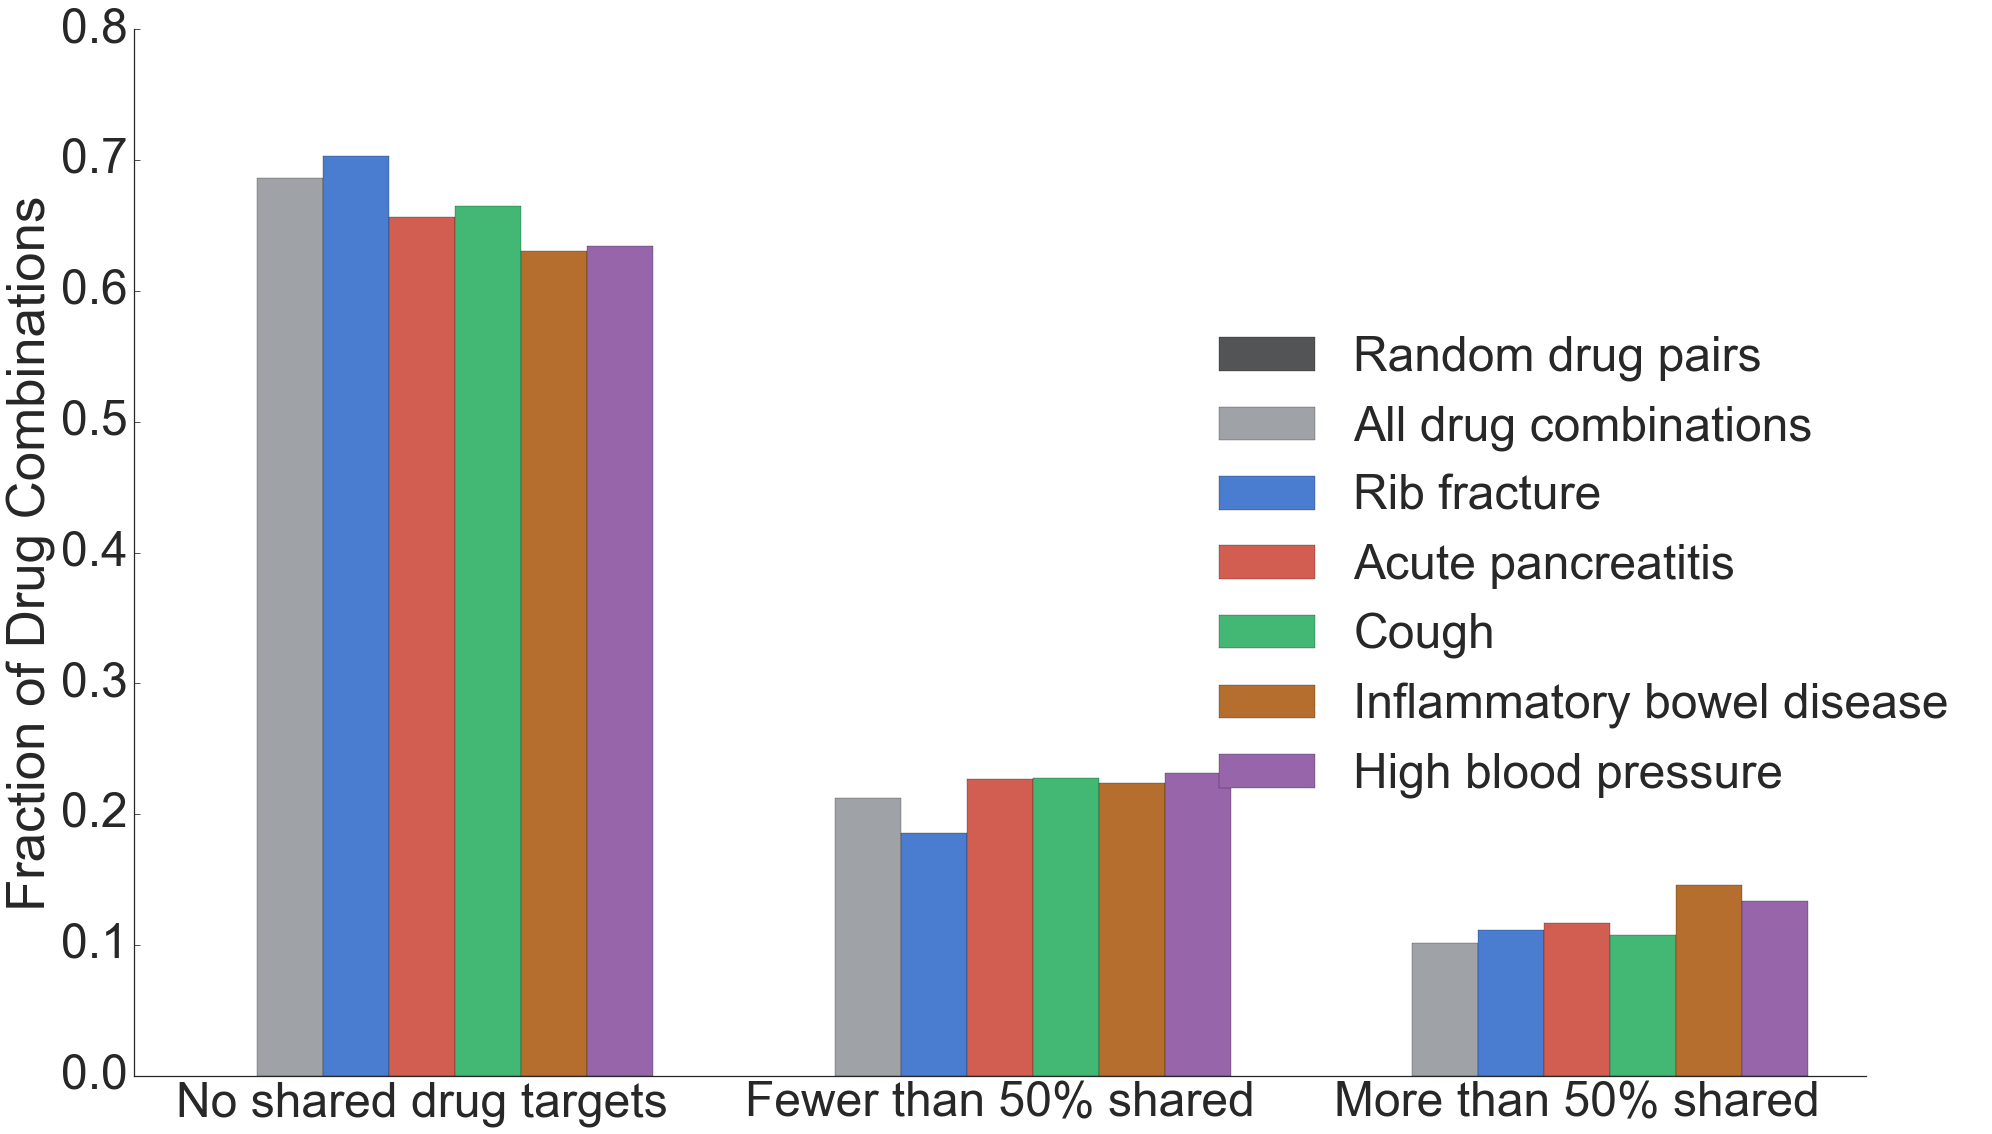

In [25]:
nicknames = {'C0035522': 'Rib fracture', 'C0001339': 'Acute pancreatitis', 'C0010200': 'Cough', 'C0021390': 'Inflammatory bowel disease', 'C0020538': 'High blood pressure'}

plot_jaccard_distribution_multiple(['C0035522', 'C0001339',  'C0010200', 'C0021390', 'C0020538'])